# Assessing Working Memory Capacity of ChatGPT

In [6]:
import os
import time
import random
import openai
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import math
from tabulate import tabulate
from scipy.stats import norm, ttest_ind, f_oneway, t, shapiro, levene, mannwhitneyu, wilcoxon, kruskal
import itertools
from matplotlib.ticker import MaxNLocator

openai.api_key = ''



In [40]:
n_list = [1, 2, 3]
blocks = 50

In [22]:
def add_noise_to_stimulus(stimulus):
    noise_symbols = list("#$%&*@^~")
    noise_length = random.randint(3, 6)
    noise = ''.join(random.sample(noise_symbols, k=noise_length))
    noisy_stimulus = list(stimulus + noise)
    random.shuffle(noisy_stimulus)
    return ''.join(noisy_stimulus)


In [43]:

# read N-back task (N=1,2,3) sequences and conditions from txt files, in which the first line is the sequence and the second line is the condition
# and create a list of trials
# each trial is a dictionary with the following keys:
# - 'stimulus': the stimulus letter
# - 'target': the desired response letter
# - 'response': the received response letter
# - 'correct': whether the response was correct
# - 'rt': the response time
random.seed(42)
all_trials = {}
for n in n_list:
    for b in range(blocks):
        path = os.path.join(os.getcwd(), 'letters','{}back'.format(n), '{}.txt'.format(b))
        with open(path, 'r') as f:
            seq = f.readline().strip()
            cond = f.readline().strip()

        # create a list of trials
        trials = []
        for i in range(len(seq)):
            trial = {}
            trial['stimulus'] = add_noise_to_stimulus(seq[i])
            trial['target'] = cond[i]
            trial['response'] = ''
            trial['correct'] = ''
            trial['rt'] = ''
            trials.append(trial)

        all_trials['{}back_{}'.format(n, b)] = trials


In [24]:
# define a function to retry requests that fail due to rate limits
def retry_request(messages, wait_time = 1, max_retries=5):
    n_try = 0
    while True:
        try:
            start_time = time.time()
            completion = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=messages
            )
            break
        except Exception as e:
            backoff_sec = wait_time * 2**(n_try+1)
            print(f"Waiting {backoff_sec} seconds...")
            time.sleep(backoff_sec)
            n_try += 1
            if n_try >= max_retries:
                print("Max retry exhausted and an error still occurs persistently.")
                raise e
    return completion,start_time

In [44]:

# First, we will run the 1-back task
for b in range(blocks):
    messages = [
        {"role": "system", "content" : "You are asked to perform a 1-back task. You will see a sequence of letters. The sequence will be presented one letter at a time, accompanied with random noise symbols chosen from '#$%&*@^~'. Please ignore the noise symbols and focus on the letter only. Your task is to respond with 'm' (no quotation marks, just the letter m) whenever the current letter is the same as the previous one, and '-' (no quotation marks, just the dash sign) otherwise. Note that you are only allowed to respond with 'm' or '-'. No explanations needed: please don't output any extra words!! Now begins the task."}
    ]
    for i in range(len(all_trials['1back_{}'.format(b)])):
          
        input = all_trials['1back_{}'.format(b)][i]['stimulus']
        
        print(f'block {b}, trial {i}: {input} (target: {all_trials["1back_{}".format(b)][i]["target"]})')
        messages.append({"role": "user", "content": input})
      
        #set a wait time of 1 second before sending the request
        time.sleep(0.1)

        completion, start_time = retry_request(messages)

        # calculate the time it took to receive the response
        response_time = time.time() - start_time
        
        # store the response time in the trial
        all_trials['1back_{}'.format(b)][i]['rt'] = response_time
        print(f"Response time: {response_time:.2f} seconds")
        
        chat_response = completion.choices[0].message.content
        print(f'ChatGPT: {chat_response}')
        
        # check if the response is 'm' or '-', if not, then the response is invalid and an error message is returned
        if chat_response == 'm':
          all_trials['1back_{}'.format(b)][i]['response'] = 'm'
          all_trials['1back_{}'.format(b)][i]['correct'] = all_trials['1back_{}'.format(b)][i]['target'] == 'm'
        elif chat_response == '-':
          all_trials['1back_{}'.format(b)][i]['response'] = '-'
          all_trials['1back_{}'.format(b)][i]['correct'] = all_trials['1back_{}'.format(b)][i]['target'] == '-'
        else:
          # Give a warning:
          print('Rule violation! Extracting the first letter of the response.')
          # extract the first letter of the response
          chat_response_0 = chat_response[0]
          while True:
            if chat_response_0 == 'm':
              all_trials['1back_{}'.format(b)][i]['response'] = 'm'
              all_trials['1back_{}'.format(b)][i]['correct'] = all_trials['1back_{}'.format(b)][i]['target'] == 'm'
              chat_response = chat_response_0
              break
            elif chat_response_0 == '-':
              all_trials['1back_{}'.format(b)][i]['response'] = '-'
              all_trials['1back_{}'.format(b)][i]['correct'] = all_trials['1back_{}'.format(b)][i]['target'] == '-'
              chat_response = chat_response_0
              break
            else:
              messages.append({"role": "assistant", "content": chat_response})
              messages.append({"role": "user", "content": "Invalid response! You must respond ONLY with 'm' or '-'. Please try again. Response:"})
              completion = openai.ChatCompletion.create(
                  model="gpt-3.5-turbo",
                  messages=messages
              )
              chat_response = completion.choices[0].message.content
              print(f'ChatGPT: {chat_response}')
              chat_response_0 = chat_response[0]

        # print 'correct' or 'incorrect' based on the response
        print('correct' if all_trials['1back_{}'.format(b)][i]['correct'] else 'incorrect')
        print('------------------------------------')
        
        messages.append({"role": "assistant", "content": chat_response})

    # wait for 5 seconds before the next block
    time.sleep(1)

block 0, trial 0: %@q# (target: -)
Response time: 0.57 seconds
ChatGPT: -
correct
------------------------------------
block 0, trial 1: $*&v (target: -)
Response time: 0.40 seconds
ChatGPT: -
correct
------------------------------------
block 0, trial 2: b^*&# (target: -)
Response time: 0.45 seconds
ChatGPT: -
correct
------------------------------------
block 0, trial 3: v*#%~ (target: -)
Response time: 0.48 seconds
ChatGPT: -
correct
------------------------------------
block 0, trial 4: ^&#%v (target: m)
Response time: 0.49 seconds
ChatGPT: - m
Rule violation! Extracting the first letter of the response.
incorrect
------------------------------------
block 0, trial 5: &*@^v# (target: m)
Response time: 1.37 seconds
ChatGPT: -
incorrect
------------------------------------
block 0, trial 6: $~@f# (target: -)
Waiting 2 seconds...
Response time: 0.40 seconds
ChatGPT: -
correct
------------------------------------
block 0, trial 7: $@%x^*& (target: -)
Response time: 0.57 seconds
ChatGPT

In [30]:

# Now for the 2-back task (Note: incorrect response time was recorded in blocks 32-37, reaction time was 1 second longer than the actual response time)
for b in range(blocks):
    messages = [
        {"role": "system", "content" : "You are asked to perform a 2-back task. You will see a sequence of letters. The sequence will be presented one letter at a time, accompanied with random noise symbols chosen from '#$%&*@^~'. Please ignore the noise symbols and focus on the letter only. Your task is to respond with 'm' (no quotation marks, just the letter m) whenever the current letter is the same as the letter two trials ago, and '-' (no quotation marks, just the dash sign) otherwise. Note that you are only allowed to respond with 'm' or '-'. No explanations needed: please don't output any extra words!! Now begins the task."}
    ]
    for i in range(len(all_trials['2back_{}'.format(b)])):
        input = all_trials['2back_{}'.format(b)][i]['stimulus']
        print(f'block {b}, trial {i}: {input} (target: {all_trials["2back_{}".format(b)][i]["target"]})')
        messages.append({"role": "user", "content": input})
        
        #set a wait time of 1 second before sending the request
        time.sleep(0.1)

        completion, start_time = retry_request(messages)

        # calculate the time it took to receive the response
        response_time = time.time() - start_time

        # store the response time in the trial
        all_trials['2back_{}'.format(b)][i]['rt'] = response_time
        print(f"Response time: {response_time:.2f} seconds")
        
        chat_response = completion.choices[0].message.content
        print(f'ChatGPT: {chat_response}')
        
        # check if the response is 'm' or '-', if not, then the response is invalid and an error message is returned
        if chat_response == 'm':
            all_trials['2back_{}'.format(b)][i]['response'] = 'm'
            all_trials['2back_{}'.format(b)][i]['correct'] = all_trials['2back_{}'.format(b)][i]['target'] == 'm'
        elif chat_response == '-':
            all_trials['2back_{}'.format(b)][i]['response'] = '-'
            all_trials['2back_{}'.format(b)][i]['correct'] = all_trials['2back_{}'.format(b)][i]['target'] == '-'
        else:
            # Give a warning:
            print('Rule violation! Trying to extract the first letter of the response.')
            # extract the first letter of the response
            chat_response_0 = chat_response[0]
            while True:
                if chat_response_0 == 'm':
                    all_trials['2back_{}'.format(b)][i]['response'] = 'm'
                    all_trials['2back_{}'.format(b)][i]['correct'] = all_trials['2back_{}'.format(b)][i]['target'] == 'm'
                    chat_response = chat_response_0
                    break
                elif chat_response_0 == '-':
                    all_trials['2back_{}'.format(b)][i]['response'] = '-'
                    all_trials['2back_{}'.format(b)][i]['correct'] = all_trials['2back_{}'.format(b)][i]['target'] == '-'
                    chat_response = chat_response_0
                    break
                else:
                    messages.append({"role": "assistant", "content": chat_response})
                    messages.append({"role": "user", "content": "Invalid response! You must respond ONLY with 'm' or '-'. Please try again. Response:"})
                    completion = openai.ChatCompletion.create(
                        model="gpt-3.5-turbo",
                        messages=messages
                    )
                    chat_response = completion.choices[0].message.content
                    print(f'ChatGPT: {chat_response}')
                    chat_response_0 = chat_response[0]

        # print 'correct' or 'incorrect' based on the response
        print('correct' if all_trials['2back_{}'.format(b)][i]['correct'] else 'incorrect')
        print('------------------------------------')
        
        messages.append({"role": "assistant", "content": chat_response})

    # wait for 5 seconds before the next block
    time.sleep(1)

block 0, trial 0: %@l# (target: -)
Response time: 0.74 seconds
ChatGPT: - (dash)
Rule violation! Trying to extract the first letter of the response.
correct
------------------------------------
block 0, trial 1: $*&f (target: -)
Response time: 0.66 seconds
ChatGPT: -
correct
------------------------------------
block 0, trial 2: n^*&# (target: -)
Response time: 0.60 seconds
ChatGPT: -
correct
------------------------------------
block 0, trial 3: y*#%~ (target: -)
Response time: 0.62 seconds
ChatGPT: -
correct
------------------------------------
block 0, trial 4: ^&#%n (target: m)
Response time: 0.51 seconds
ChatGPT: m
correct
------------------------------------
block 0, trial 5: &*@^z# (target: -)
Response time: 0.51 seconds
ChatGPT: -
correct
------------------------------------
block 0, trial 6: $~@z# (target: -)
Response time: 0.46 seconds
ChatGPT: -
correct
------------------------------------
block 0, trial 7: $@%w^*& (target: -)
Response time: 0.50 seconds
ChatGPT: -
correct
-

In [31]:

# Now for the 3-back task
for b in range(blocks):
    messages = [
        {"role": "system", "content" : "You are asked to perform a 3-back task. You will see a sequence of letters. The sequence will be presented one letter at a time, accompanied with random noise symbols chosen from '#$%&*@^~'. Please ignore the noise symbols and focus on the letter only. Your task is to respond with 'm' (no quotation marks, just the letter m) whenever the current letter is the same as the letter three trials ago, and '-' (no quotation marks, just the dash sign) otherwise. Note that you are only allowed to respond with 'm' or '-'. No explanations needed: please don't output any extra words!! Now begins the task."}
    ]
    for i in range(len(all_trials['3back_{}'.format(b)])):
        input = all_trials['3back_{}'.format(b)][i]['stimulus']
        print(f'block {b}, trial {i}: {input} (target: {all_trials["3back_{}".format(b)][i]["target"]})')
        messages.append({"role": "user", "content": input})

        #set a wait time of 1 second before sending the request
        time.sleep(0.1)
        
        completion, start_time = retry_request(messages)
    
        # calculate the time it took to receive the response
        response_time = time.time() - start_time
        # store the response time in the trial
        all_trials['3back_{}'.format(b)][i]['rt'] = response_time
        print(f"Response time: {response_time:.2f} seconds")
        
        chat_response = completion.choices[0].message.content
        print(f'ChatGPT: {chat_response}')
        
        # check if the response is 'm' or '-', if not, then the response is invalid and an error message is returned
        if chat_response == 'm':
            all_trials['3back_{}'.format(b)][i]['response'] = 'm'
            all_trials['3back_{}'.format(b)][i]['correct'] = all_trials['3back_{}'.format(b)][i]['target'] == 'm'
        elif chat_response == '-':
            all_trials['3back_{}'.format(b)][i]['response'] = '-'
            all_trials['3back_{}'.format(b)][i]['correct'] = all_trials['3back_{}'.format(b)][i]['target'] == '-'
        else:
            # Give a warning:
            print('Rule violation! Extracting the first letter of the response.')
            # extract the first letter of the response
            chat_response_0 = chat_response[0]
            while True:
                if chat_response_0 == 'm':
                    all_trials['3back_{}'.format(b)][i]['response'] = 'm'
                    all_trials['3back_{}'.format(b)][i]['correct'] = all_trials['3back_{}'.format(b)][i]['target'] == 'm'
                    chat_response = chat_response_0
                    break
                elif chat_response_0 == '-':
                    all_trials['3back_{}'.format(b)][i]['response'] = '-'
                    all_trials['3back_{}'.format(b)][i]['correct'] = all_trials['3back_{}'.format(b)][i]['target'] == '-'
                    chat_response = chat_response_0
                    break
                else:
                    messages.append({"role": "assistant", "content": chat_response})
                    messages.append({"role": "user", "content": "Invalid response! You must respond ONLY with 'm' or '-'. Please try again. Response:"})
                    completion = openai.ChatCompletion.create(
                        model="gpt-3.5-turbo",
                        messages=messages
                    )
                    chat_response = completion.choices[0].message.content
                    print(f'ChatGPT: {chat_response}')
                    chat_response_0 = chat_response[0]

            
        # print 'correct' or 'incorrect' based on the response
        print('correct' if all_trials['3back_{}'.format(b)][i]['correct'] else 'incorrect')
        print('------------------------------------')

        messages.append({"role": "assistant", "content": chat_response})

    # wait for 5 seconds before the next block
    time.sleep(1)


block 0, trial 0: &$@t^# (target: -)
Response time: 0.66 seconds
ChatGPT: - (dash)
Rule violation! Extracting the first letter of the response.
correct
------------------------------------
block 0, trial 1: &$r~ (target: -)
Response time: 0.50 seconds
ChatGPT: -
correct
------------------------------------
block 0, trial 2: *@j^$%~ (target: -)
Response time: 0.51 seconds
ChatGPT: -
correct
------------------------------------
block 0, trial 3: $#&g (target: -)
Response time: 0.52 seconds
ChatGPT: -
correct
------------------------------------
block 0, trial 4: @$r~ (target: m)
Response time: 0.44 seconds
ChatGPT: -
incorrect
------------------------------------
block 0, trial 5: @~%k$#* (target: -)
Response time: 0.45 seconds
ChatGPT: -
correct
------------------------------------
block 0, trial 6: ^&#y* (target: -)
Response time: 0.53 seconds
ChatGPT: -
correct
------------------------------------
block 0, trial 7: q%&^ (target: -)
Response time: 0.80 seconds
ChatGPT: -
correct
------

In [55]:
# save all_trials to a json file
with open('all_trials_verbal_noise.json', 'w') as f:
    json.dump(all_trials, f)


In [33]:
# load all_trials from a json file
# with open('all_trials_letters_feedback.json', 'r') as f:
#     all_trials = json.load(f)

In [46]:
n_list = [1, 2, 3]
def compute_summary_stats(all_trials, n_list, blocks):
    summary_stats = {}
    raw_data = {}
    for n in n_list:
        hit_rate, false_alarm_rate, accuracy, response_time, d_prime = [], [], [], [], []
        for b in range(blocks):
            trials = all_trials[f"{n}back_{b}"]

            # Compute the hit rate, false alarm rate, and response time
            hits, false_alarms, total_targets, total_lures, total_rt = 0, 0, 0, 0, 0
            for trial in trials:
                if trial['target'] == 'm':
                    total_targets += 1
                    if trial['correct']:
                        hits += 1
                        total_rt += trial['rt']
                else:
                    total_lures += 1
                    if not trial['correct']:
                        false_alarms += 1

            hit_rate.append((hits / total_targets) * 100)
            false_alarm_rate.append((false_alarms / total_lures) * 100)
            accuracy.append(((hits + (total_lures - false_alarms)) / (total_targets + total_lures)) * 100)
            response_time.append(total_rt / hits if hits > 0 else np.nan)

            # Compute d prime
            hit_rate_adjusted = np.clip(hits / total_targets, 0.01, 0.99)
            false_alarm_rate_adjusted = np.clip(false_alarms / total_lures, 0.01, 0.99)
            d_prime.append(np.abs(norm.ppf(hit_rate_adjusted) - norm.ppf(false_alarm_rate_adjusted)))

        raw_data[n] = {
            "hit_rate": hit_rate,
            "false_alarm_rate": false_alarm_rate,
            "accuracy": accuracy,
            "d_prime": d_prime
        }
            
        summary_stats[n] = {
            "hit_rate": {"mean": np.mean(hit_rate),  "stderr": np.std(hit_rate) / math.sqrt(blocks)},
            "false_alarm_rate": {"mean": np.mean(false_alarm_rate), "stderr": np.std(false_alarm_rate) / math.sqrt(blocks)},
            "accuracy": {"mean": np.mean(accuracy), "stderr": np.std(accuracy) / math.sqrt(blocks)},
            "d_prime": {"mean": np.mean(d_prime), "stderr": np.std(d_prime) / math.sqrt(blocks)}
        }
    return summary_stats, raw_data

def create_table(summary_stats, n_list):
    headers = ["N-back", "Hit Rate (%)", "False Alarm Rate (%)",
               "Accuracy (%)", "D Prime"]

    table_data = []
    for n in n_list:
        row = [f"{n}-back",
               f"{summary_stats[n]['hit_rate']['mean']:.2f} ± {summary_stats[n]['hit_rate']['stderr']:.2f}",
               f"{summary_stats[n]['false_alarm_rate']['mean']:.2f} ± {summary_stats[n]['false_alarm_rate']['stderr']:.2f}",
               f"{summary_stats[n]['accuracy']['mean']:.2f} ± {summary_stats[n]['accuracy']['stderr']:.2f}",
               f"{summary_stats[n]['d_prime']['mean']:.2f} ± {summary_stats[n]['d_prime']['stderr']:.2f}"]
        table_data.append(row)

    table_str = tabulate(table_data, headers=headers, tablefmt="latex_booktabs")
    return table_str

# Compute summary statistics
summary_stats, raw_data = compute_summary_stats(all_trials, n_list, blocks)

# Create and print the table in LaTeX format
latex_table = create_table(summary_stats, n_list)
print(latex_table)


\begin{tabular}{lllll}
\toprule
 N-back   & Hit Rate (\%)   & False Alarm Rate (\%)   & Accuracy (\%)   & D Prime     \\
\midrule
 1-back   & 11.25 ± 1.51   & 0.25 ± 0.17            & 11.00 ± 1.54   & 0.89 ± 0.09 \\
 2-back   & 7.25 ± 1.12    & 2.38 ± 0.46            & 4.88 ± 1.36    & 0.76 ± 0.07 \\
 3-back   & 6.25 ± 0.88    & 2.25 ± 0.46            & 4.00 ± 1.11    & 0.71 ± 0.07 \\
\bottomrule
\end{tabular}


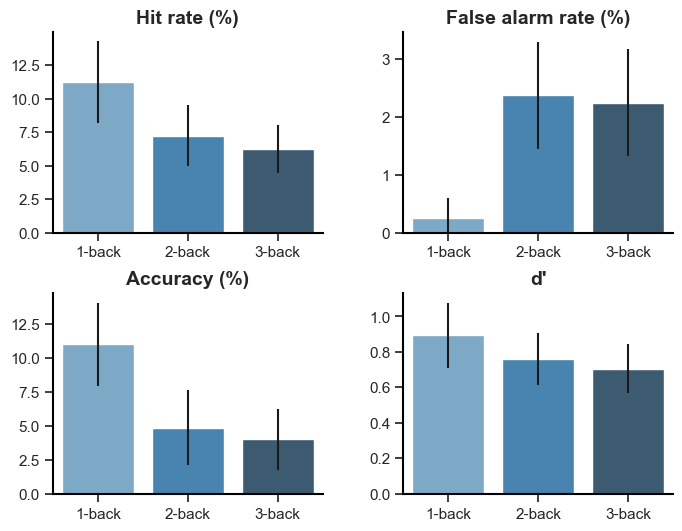

In [56]:
def plot_metrics(summary_stats, n_list, ci_level=0.95):
    # Set seaborn style and font size
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 12})

    # Bar plot for accuracy, hit rate, false alarm rate, and d prime
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    metrics = ["hit_rate", "false_alarm_rate","accuracy", "d_prime"]
    titles = ["Hit rate (%)", "False alarm rate (%)", "Accuracy (%)", "d'"]

    for i, ax in enumerate(axes.flat):
        metric = metrics[i]
        means = [summary_stats[n][metric]["mean"] for n in n_list]
        stderrs = [summary_stats[n][metric]["stderr"] for n in n_list]
        # Compute 95% confidence intervals
        critical_value = t.ppf((1 + ci_level) / 2, blocks - 1)
        cis = [critical_value * stderr for stderr in stderrs]
        # Choose either standard errors or confidence intervals for error bars
        error_bars = cis # Change this to 'stderrs' for standard errors
        bar_plot = sns.barplot(x=n_list, y=means, yerr=error_bars, ax=ax, palette="Blues_d")
        ax.set_title(titles[i], fontsize=14, fontweight='bold')
        ax.set_xticklabels([f"{n}-back" for n in n_list])
        ax.set_ylim(bottom=0)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # remove the grid lines
        ax.grid(False)
        # set the weight  and color of axes lines
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        # show tick lines on the left and bottom axes
        ax.tick_params(axis='both', which='both', bottom=True, left=True)


    # layout setting: adjust the space between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()
    
    # save the figure to a svg file in the figures folder
    fig.savefig(os.path.join("figures", "verbal_with_noise.svg"), format="svg")

plot_metrics(summary_stats, n_list)



In [48]:
def statistical_test(summary_stats, raw_data, n_list, blocks, alpha=0.05):
    metrics = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]

    for metric in metrics:
        print(f"ANOVA for {metric}:")

        # Prepare the data for ANOVA
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform ANOVA
        F, p = f_oneway(*data)

        # Calculate degrees of freedom
        df_between = len(n_list) - 1
        df_within = blocks * len(n_list) - len(n_list)

        # Calculate partial eta squared
        ss_total = np.sum([(d - np.mean(data))**2 for d in itertools.chain.from_iterable(data)])
        ss_effect = sum(blocks * (np.mean(data[i]) - np.mean(np.concatenate(data)))**2 for i in range(len(n_list)))
        partial_eta_squared = ss_effect / (ss_effect + ss_total)

        print(f"  F({df_between}, {df_within}) = {F:.4f}, p = {p:.4f}, partial eta squared = {partial_eta_squared:.4f}")

        # Perform post-hoc t-tests
        print("  Post-hoc t-tests:")
        for combo in itertools.combinations(n_list, 2):
            n1, n2 = combo
            data1 = raw_data[n1][metric]
            data2 = raw_data[n2][metric]

            # t-test
            t_stat, p_value = ttest_ind(data1, data2)

            # Calculate degrees of freedom for t-test
            df_t = 2 * blocks - 2

            # Bonferroni correction
            corrected_p = min(p_value * len(list(itertools.combinations(n_list, 2))), 1)

            # Calculate Cohen's d
            pooled_std = np.sqrt((np.std(data1)**2 + np.std(data2)**2) / 2)
            cohen_d = (np.mean(data1) - np.mean(data2)) / pooled_std

            print(f"    {n1}-back vs {n2}-back: t({df_t}) = {t_stat:.4f}, p = {corrected_p:.4f}, Cohen's d = {cohen_d:.4f}")

        print()

statistical_test(summary_stats, raw_data, n_list, blocks)

ANOVA for hit_rate:
  F(2, 147) = 4.7598, p = 0.0099, partial eta squared = 0.0573
  Post-hoc t-tests:
    1-back vs 2-back: t(98) = 2.1039, p = 0.1139, Cohen's d = 0.4250
    1-back vs 3-back: t(98) = 2.8284, p = 0.0170, Cohen's d = 0.5714
    2-back vs 3-back: t(98) = 0.6927, p = 1.0000, Cohen's d = 0.1399

ANOVA for false_alarm_rate:
  F(2, 147) = 9.1561, p = 0.0002, partial eta squared = 0.0997
  Post-hoc t-tests:
    1-back vs 2-back: t(98) = -4.2473, p = 0.0001, Cohen's d = -0.8581
    1-back vs 3-back: t(98) = -4.0310, p = 0.0003, Cohen's d = -0.8144
    2-back vs 3-back: t(98) = 0.1895, p = 1.0000, Cohen's d = 0.0383

ANOVA for accuracy:
  F(2, 147) = 7.8379, p = 0.0006, partial eta squared = 0.0879
  Post-hoc t-tests:
    1-back vs 2-back: t(98) = 2.9537, p = 0.0118, Cohen's d = 0.5967
    1-back vs 3-back: t(98) = 3.6503, p = 0.0013, Cohen's d = 0.7375
    2-back vs 3-back: t(98) = 0.4923, p = 1.0000, Cohen's d = 0.0995

ANOVA for d_prime:
  F(2, 147) = 1.4670, p = 0.2340, pa

In [49]:
# check the normality of the data
def check_normality(raw_data, n_list, blocks):
    metrics = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]

    for metric in metrics:
        print(f"Normality test for {metric}:")

        # Prepare the data for normality test
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform normality test
        W, p = shapiro(np.concatenate(data))

        print(f"  W = {W:.4f}, p = {p:.4f}")

        print()

check_normality(raw_data, n_list, blocks)


Normality test for hit_rate:
  W = 0.7365, p = 0.0000

Normality test for false_alarm_rate:
  W = 0.5595, p = 0.0000

Normality test for accuracy:
  W = 0.8708, p = 0.0000

Normality test for d_prime:
  W = 0.8473, p = 0.0000



In [50]:
# check the homogeneity of the variance
def check_homogeneity(raw_data, n_list, blocks):
    metrics = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]

    for metric in metrics:
        print(f"Levene's test for {metric}:")

        # Prepare the data for homogeneity test
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform homogeneity test
        W, p = levene(*data)

        print(f"  W = {W:.4f}, p = {p:.4f}")

        print()

check_homogeneity(raw_data, n_list, blocks)


Levene's test for hit_rate:
  W = 0.4506, p = 0.6381

Levene's test for false_alarm_rate:
  W = 9.1561, p = 0.0002

Levene's test for accuracy:
  W = 0.7356, p = 0.4810

Levene's test for d_prime:
  W = 0.3313, p = 0.7186



Distribution plot for hit_rate:


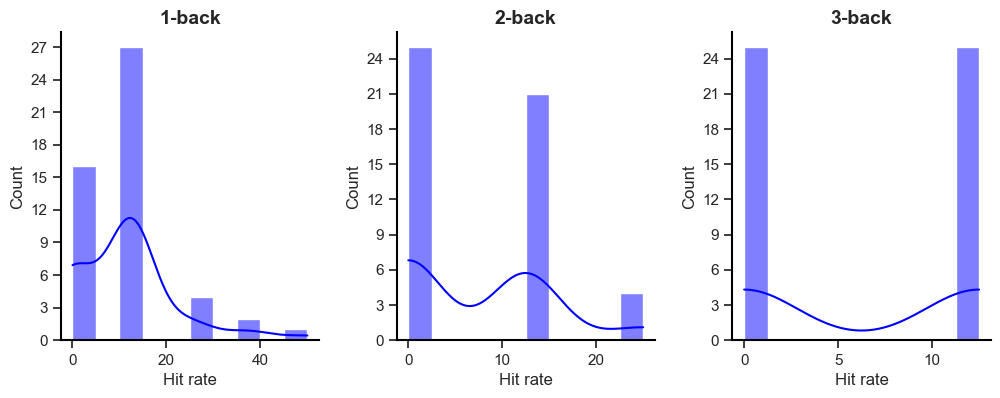

Distribution plot for false_alarm_rate:


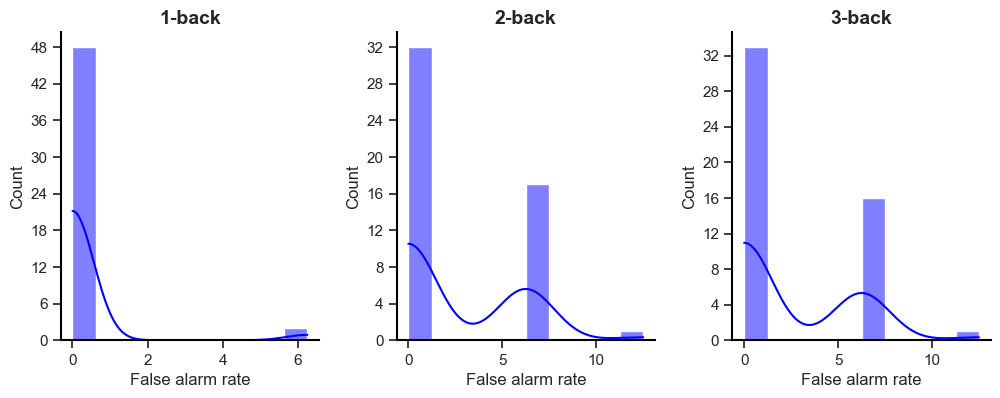

Distribution plot for accuracy:


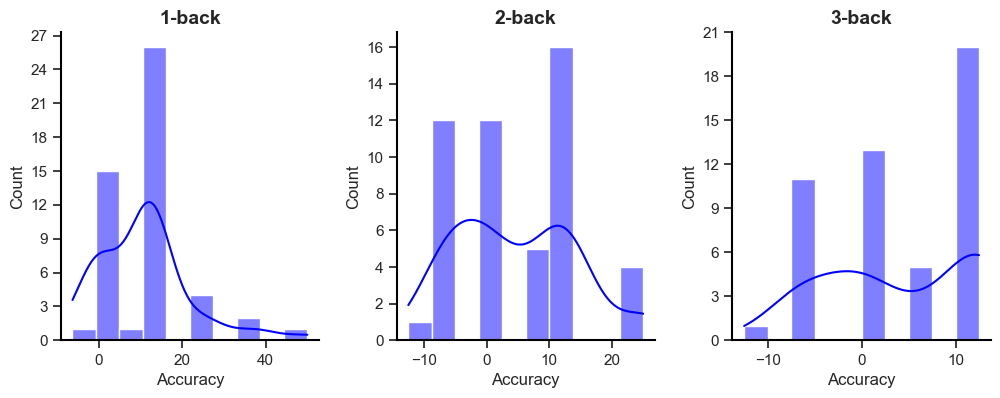

Distribution plot for d_prime:


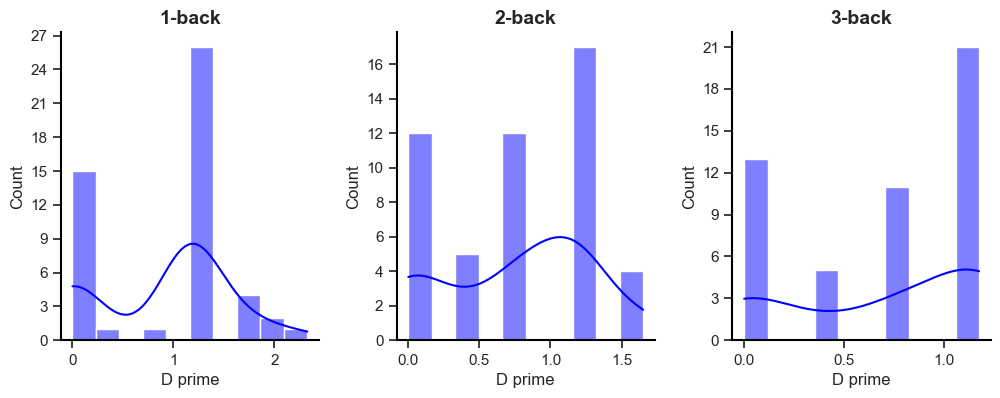

In [51]:
# plot the distribution of the data
def plot_distribution(raw_data, n_list, blocks):
    metrics = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]

    for metric in metrics:
        print(f"Distribution plot for {metric}:")

        # Prepare the data for distribution plot
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform distribution plot
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        for i, ax in enumerate(axes.flat):
            sns.histplot(data[i], ax=ax, color="blue", bins=10, kde=True, stat='count')
            # sns.displot(data[i], ax=ax, kde=True, color="black")
            # sns.distplot(data[i], ax=ax, color="blue")
            ax.set_title(f"{n_list[i]}-back", fontsize=14, fontweight='bold')
            ax.set_xlabel(metric.replace("_", " ").capitalize())
            ax.set_ylabel("Count")
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # remove the grid lines
            ax.grid(False)
            # set the weight  and color of axes lines
            ax.spines['bottom'].set_linewidth(1.5)
            ax.spines['left'].set_linewidth(1.5)
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            # show tick lines on the left and bottom axes
            ax.tick_params(axis='both', which='both', bottom=True, left=True)
            # set y ticks to be integers
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        # layout setting: adjust the space between subplots
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        plt.show()

plot_distribution(raw_data, n_list, blocks)

In [54]:
# as normality test and homogeneity test show that the data is not normal and the variance is not homogeneous, we use the non-parametric test
def nonparametric_test(summary_stats, raw_data, n_list, blocks, alpha=0.05):
    metrics = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]

    for metric in metrics:
        print(f"Kruskal-Wallis test for {metric}:")

        # Prepare the data for Kruskal-Wallis test
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform Kruskal-Wallis test
        H, p = kruskal(*data)

        # Calculate degrees of freedom
        df = len(n_list) - 1

        # Calculate the total number of observations
        N = len(raw_data[n_list[0]][metric]) * len(n_list)
        
        # Calculate epsilon squared (ε²):ε² = (H - k + 1) / (N - k), where H is the Kruskal-Wallis H statistic, k is the number of groups (in your case, len(n_list)), N is the total number of observations across all groups
        epsilon_squared = (H - len(n_list) + 1) / (N - len(n_list))

        print(f"  H({df}) = {H:.4f}, p = {p:.4f}, epsilon squared = {epsilon_squared:.4f}")

        # Perform post-hoc Mann-Whitney U test
        print("  Post-hoc Mann-Whitney U test:")
        for combo in itertools.combinations(n_list, 2):
            n1, n2 = combo
            data1 = raw_data[n1][metric]
            data2 = raw_data[n2][metric]

            # Mann-Whitney U test
            U, p_value = mannwhitneyu(data1, data2)

            # Bonferroni correction
            corrected_p = min(p_value * len(list(itertools.combinations(n_list, 2))), 1)

            # Calculate the effect size using the rank-biserial correlation (r): r = 1 – (2U)/ (n1 * n2)
            r = 1 - (2 * U) / (len(data1) * len(data2))

            print(f"    {n1}-back vs {n2}-back: U = {U:.4f}, p = {corrected_p:.4f}, rank-biserial correlation(r) = {r:.4f}")

        print()

nonparametric_test(summary_stats, raw_data, n_list, blocks)

Kruskal-Wallis test for hit_rate:
  H(2) = 6.4758, p = 0.0392, epsilon squared = 0.0304
  Post-hoc Mann-Whitney U test:
    1-back vs 2-back: U = 1500.5000, p = 0.1711, rank-biserial correlation(r) = -0.2004
    1-back vs 3-back: U = 1562.5000, p = 0.0467, rank-biserial correlation(r) = -0.2500
    2-back vs 3-back: U = 1300.0000, p = 1.0000, rank-biserial correlation(r) = -0.0400

Kruskal-Wallis test for false_alarm_rate:
  H(2) = 17.1933, p = 0.0002, epsilon squared = 0.1034
  Post-hoc Mann-Whitney U test:
    1-back vs 2-back: U = 849.0000, p = 0.0002, rank-biserial correlation(r) = 0.3208
    1-back vs 3-back: U = 874.0000, p = 0.0004, rank-biserial correlation(r) = 0.3008
    2-back vs 3-back: U = 1274.5000, p = 1.0000, rank-biserial correlation(r) = -0.0196

Kruskal-Wallis test for accuracy:
  H(2) = 12.7755, p = 0.0017, epsilon squared = 0.0733
  Post-hoc Mann-Whitney U test:
    1-back vs 2-back: U = 1649.5000, p = 0.0114, rank-biserial correlation(r) = -0.3196
    1-back vs 3-